# Trainfeed forward ANN and look for hierarchy

In [13]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
input_size = 784 # 28x28
hidden_size = 3*[512]
num_classes = 10
num_epochs = 1
batch_size = 100
learning_rate = 1e-4
device = 'cpu'

## Load Standard MNIST Dataset

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=True, 
                                       transform=transforms.ToTensor(),  
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        transform=transforms.ToTensor()) 


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) 


## Create simple MLP

In [3]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size: list, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden = nn.ModuleList([nn.Linear(input_size, hidden_size[0]), nn.ReLU()])
        for i, hs in enumerate(hidden_size[1:]):
            self.hidden.extend([nn.Linear(hidden_size[i], hs), nn.ReLU()])
        self.out_proj = nn.Linear(hidden_size[-1], num_classes)   


    def forward(self, x):
        hidden_activations = []
        for idx, layer in enumerate(self.hidden):
            x = layer(x)
            if idx % 2 == 0:
                # return hidden activations for later analysis
                hidden_activations.append(x)
        out = self.out_proj(x)
        # no activation and no softmax at the end
        return out, hidden_activations

## Training Loop

In [17]:

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 


n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        if (i+1) % 100 == 0:
             print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/1], Step[100/600], Loss: 0.6890
Epoch [1/1], Step[200/600], Loss: 0.5550
Epoch [1/1], Step[300/600], Loss: 0.3885
Epoch [1/1], Step[400/600], Loss: 0.3487
Epoch [1/1], Step[500/600], Loss: 0.2670
Epoch [1/1], Step[600/600], Loss: 0.4017


## Test Loop

In [18]:
with torch.no_grad():
     n_correct = 0
     n_samples = 0
     hidden_activities = []
     all_labels = []
     for images, labels in test_loader:
         images = images.reshape(-1, 28*28).to(device)
         labels = labels.to(device)
         outputs, hidden_act = model(images)
         hidden_activities.append(hidden_act)
         all_labels.append(labels)
         # max returns (value ,index)
         _, predicted = torch.max(outputs.data, 1)
         n_samples += labels.size(0)
         n_correct += (predicted == labels).sum().item() 
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc} %') 
all_labels = torch.cat(all_labels, 0)

Accuracy of the network on the 10000 test images: 92.62 %


## Analyze the weights directly

/tmp/ipykernel_1390811/3502416521.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


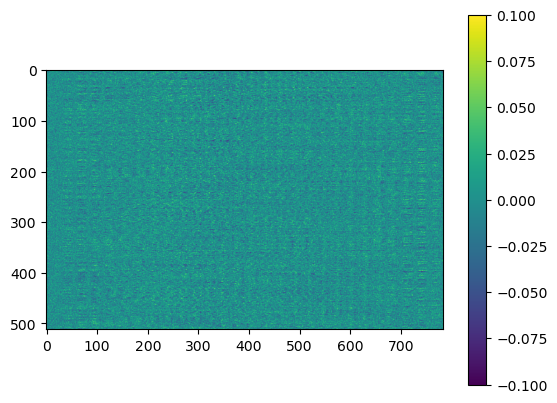

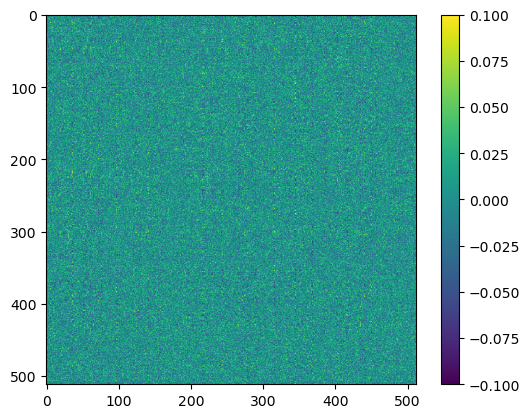

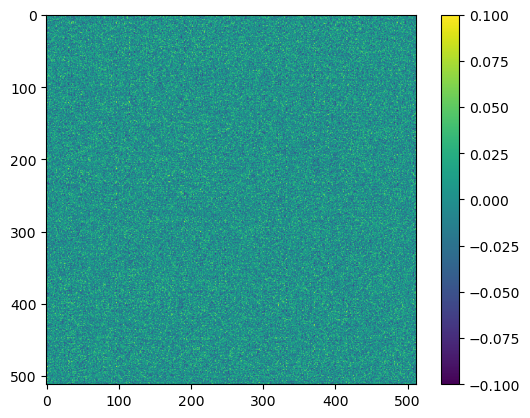

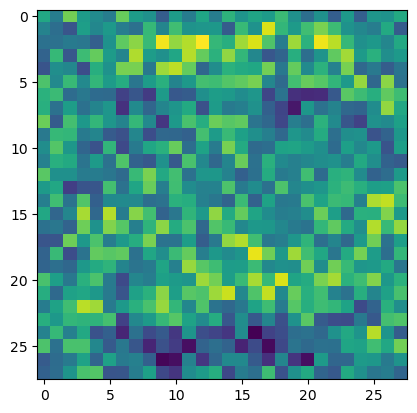

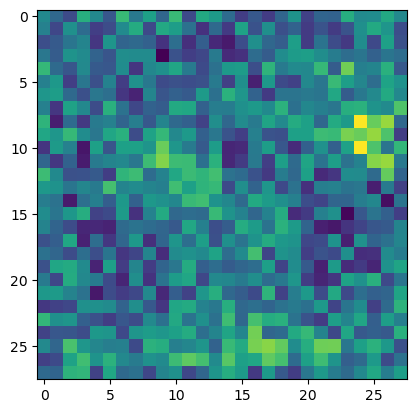

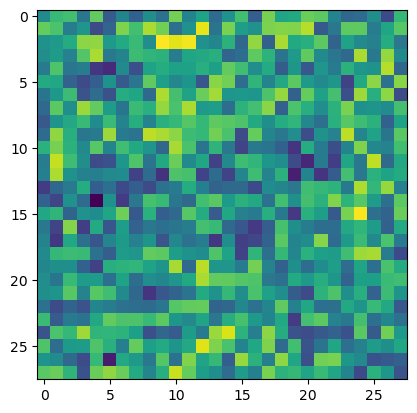

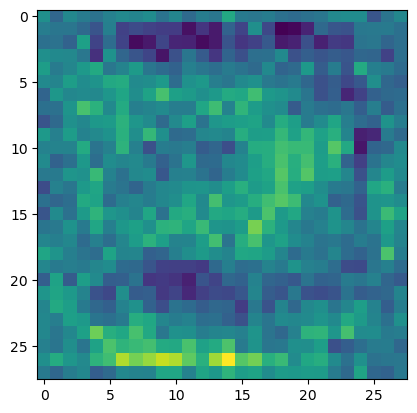

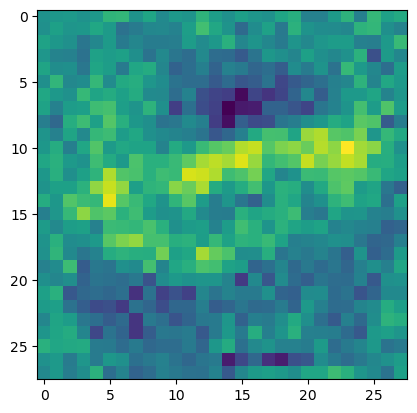

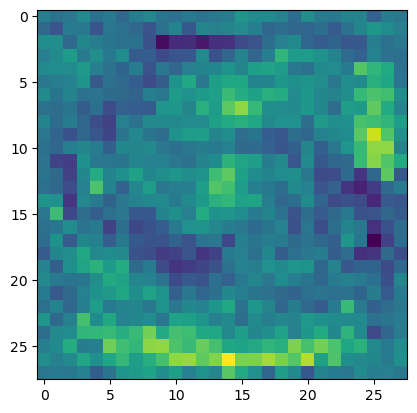

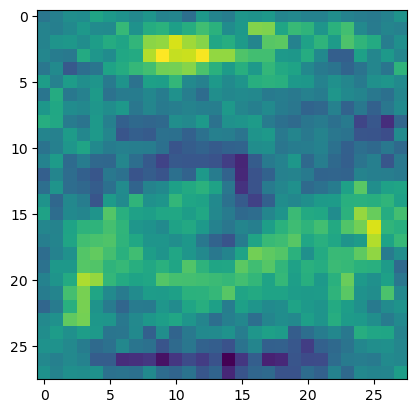

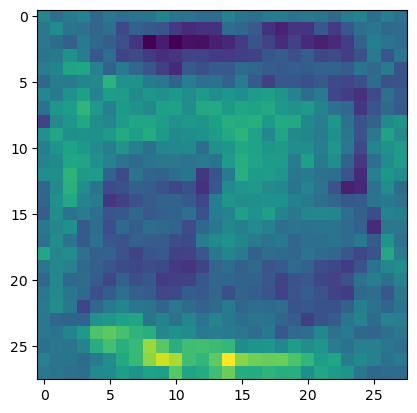

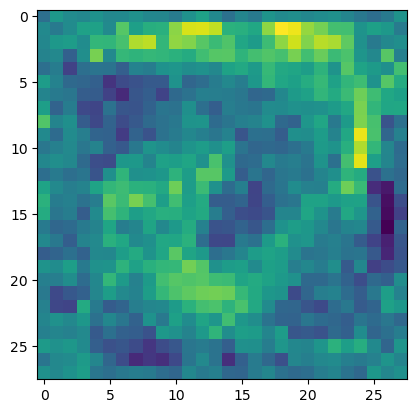

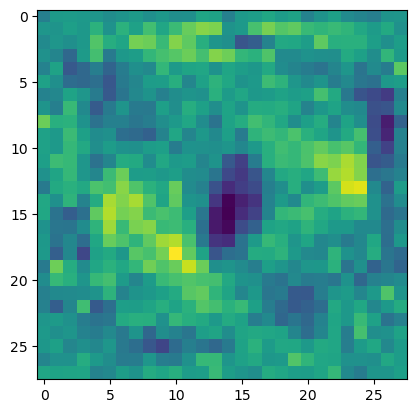

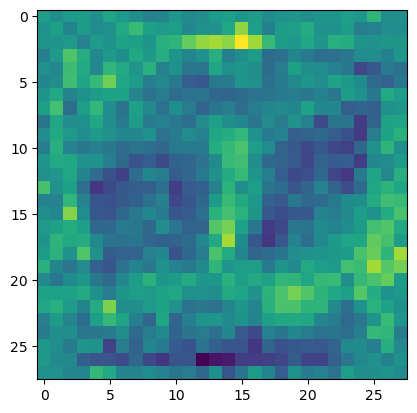

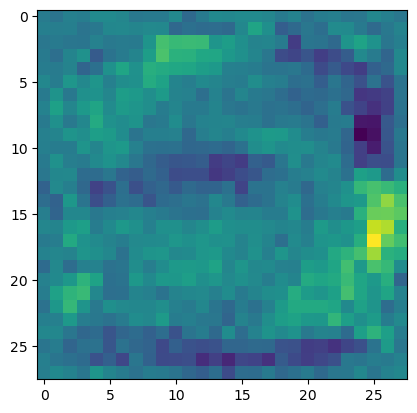

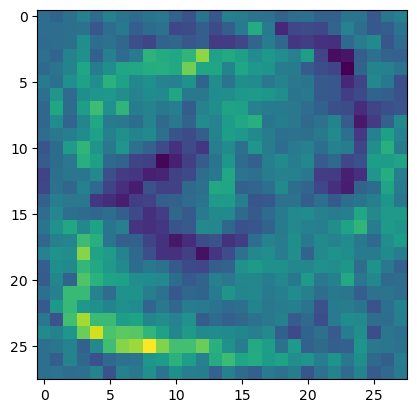

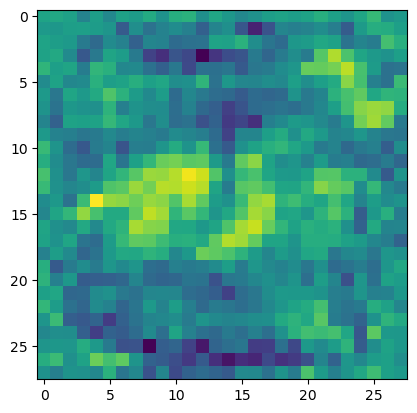

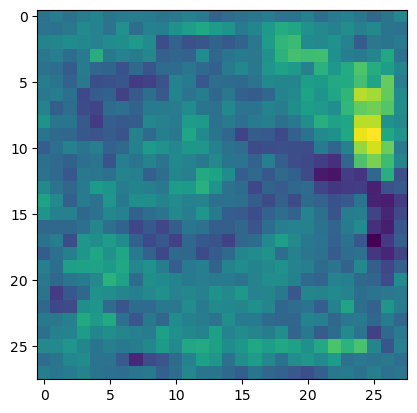

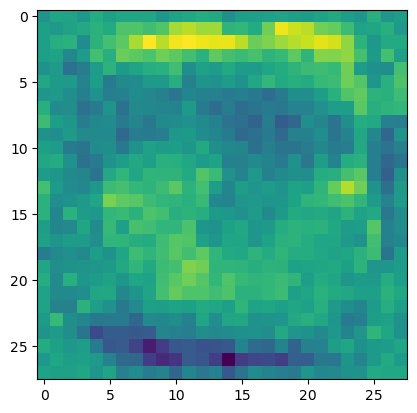

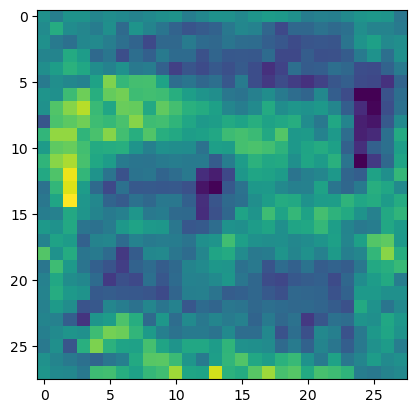

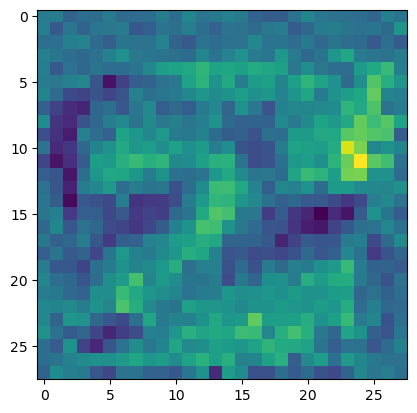

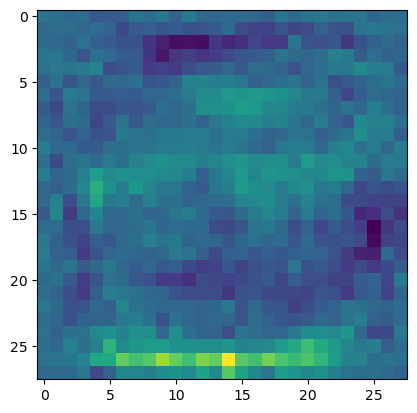

In [11]:
layers = [model.hidden[0].weight]
prev_layer = layers[0]
for i in range(2, 2*len(hidden_size), 2):
    layers.append(model.hidden[i].weight @ prev_layer)
    prev_layer = layers[-1]
final = model.out_proj.weight @ prev_layer
for i in range(0, len(layers)):
    plt.figure()
    plt.imshow(model.hidden[2*i].weight.detach(), vmax=1e-1, vmin=-1e-1)
    plt.colorbar()
for l in range(len(layers)):
    for i in range(0,3):
        plt.figure()
        plt.imshow(layers[l][i].view(28, 28).detach())
for i in range(10):
    plt.figure()
    plt.imshow(final[i].view(28, 28).detach())

## Analyze the activations of the hidden layers and do PCA 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


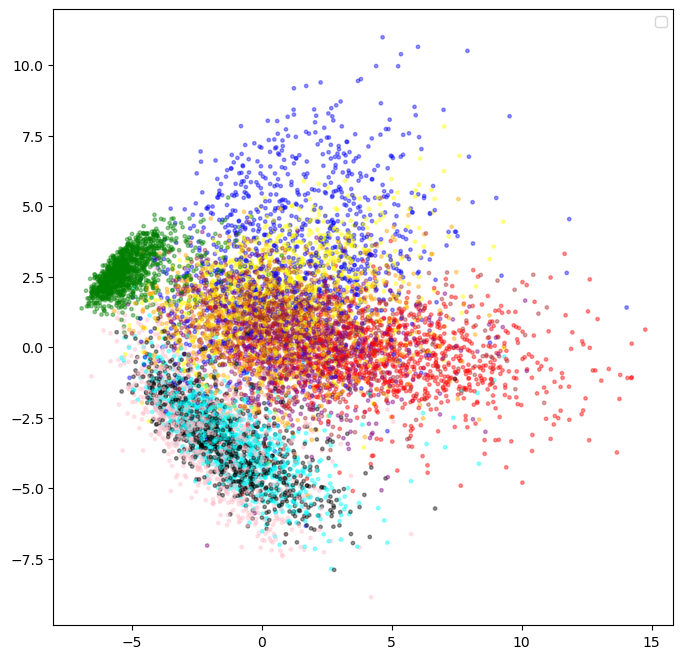

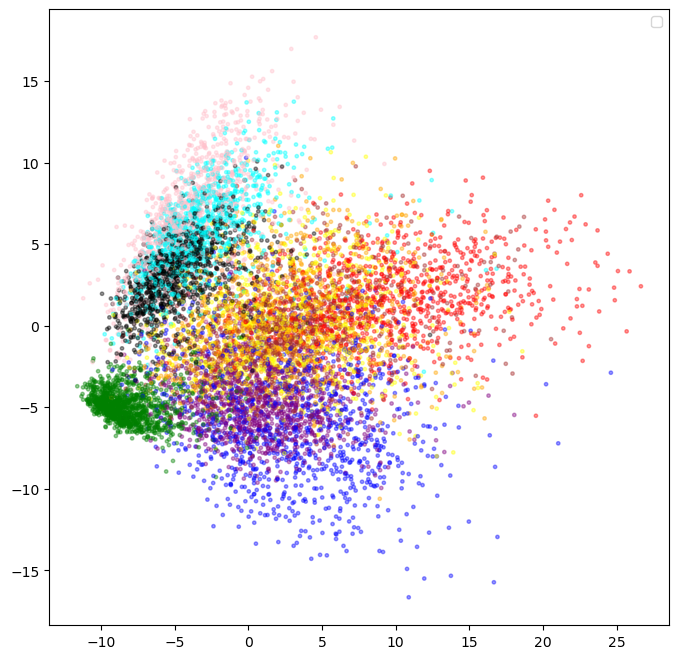

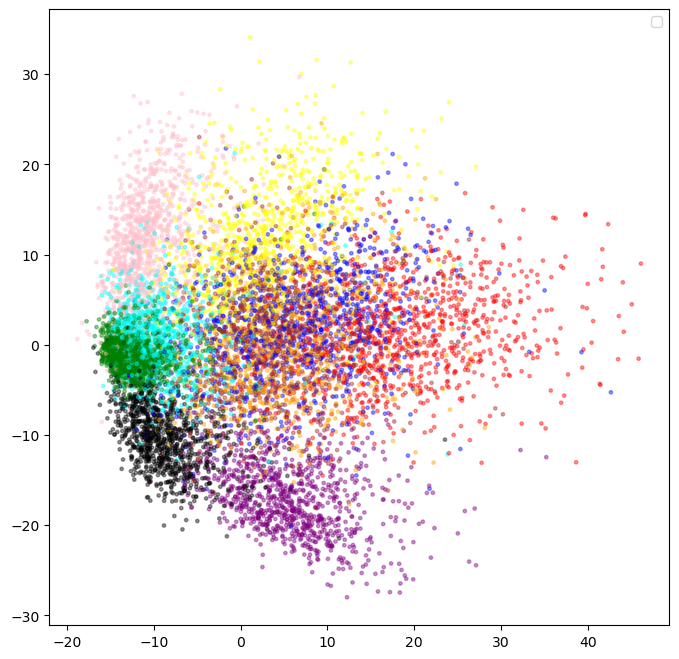

In [19]:
hidden_activities_transformed = []
for i in range(len(hidden_size)):
    hidden_activities_transformed.append(torch.cat([h[i] for h in hidden_activities]))


from sklearn.decomposition import PCA
from tqdm import tqdm
color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'cyan']
colors = [color_list[i] for i in all_labels]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    hat_pca = pca.fit_transform(hat.detach().numpy())
    plt.figure(figsize=(8,8))
    plt.scatter(hat_pca[:,0], hat_pca[:,1], s=6, c=colors, alpha=0.4)
    plt.legend()